In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


In [2]:
import numpy as np
from matplotlib.pyplot import *
import npp

In [3]:
import matplotlib
matplotlib.rc('image', cmap='gray_r')
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

rtitle = lambda t: matplotlib.pyplot.title(t, y=1.2)
def matshow_symm(data, *args, **kwargs):
    maxabs = np.abs(data[~np.isnan(data)]).max()
    matshow(data, *args, vmin=-maxabs, vmax=maxabs, **kwargs)

In [4]:
%load_ext autoreload
%autoreload 2

## Create fake dataset with specific variance properties

In [173]:
def make_params():
    # partitions are always listed in the order (A, B, C, AB, AC, BC, ABC)
    part_names = ('A', 'B', 'C', 'AB', 'AC', 'BC', 'ABC')

    # which partitions are combined to get each full feature space?
    combs = [[0, 3, 4, 6],
             [1, 3, 5, 6],
             [2, 4, 5, 6]]

    # total_variance is total fraction of non-noise variance in responses
    total_variance = 0.02

    # true_variances is proportion of variance assigned to each partition
    #true_variances = np.ones(7) # each partition is equal
    #true_variances = np.array([1088, 662, 9501, 251, 284, 1872, 555]).astype(float) # values from speech experiment
    true_variances = np.array([1088, 0, 0, 251, 284, 1872, 555]).astype(float) # values from speech experiment
    #true_variances = np.array([1, 1, 1, 1, 1, 1, 1])
    true_variances = true_variances / float(true_variances.sum()) * total_variance

    noise_variance = 1.0 - true_variances.sum()

    # P_parts is number of components that together describe the variance in each partition
    #P_parts = [1] * 7 # 1 component in each partition
    #P_parts = [10] * 7 # 10 component in each partition
    #P_parts = [10, 10, 900, 10, 10, 10, 10]
    P_parts = [1, 1, 10, 1, 1, 1, 2]

    # P_models contains size of each feature space (each must be bigger than sum of constituent parts)
    P_models = [300, 22, 985] # like speech experiment
    #P_models = [1200, 88, 3940] # REALLY like speech experiment
    #P_models = [50, 50, 50]
    #P_models = [9, 5, 19] # like Mark's experiment

    # Pnoise_models is number of noise features in each feature space
    Pnoise_models = [P - np.array(P_parts)[c].sum() for P,c in zip(P_models, combs)]

    # N_R is number of training (regression) timepoints, N_P is number of validation (prediction) timepoints
    #N_R, N_P = 3737, 300 # like speech experiment
    N_R, N_P = 1260, 126 # like Mark's experiment

    # M is number of voxels to simulate
    M = 1000

    data_params = locals()
    return data_params

data_params = make_params()

In [174]:
from varpart import make_data, compare

# Create dataset
data = make_data(use_mixing=True, orthogonalize=True, noise_scale=1.0, **data_params)

X_parts[0].shape (1, 1386)
Btrue_parts[0].shape (1, 1000)
Y_parts[0].shape (1386, 1000)
scaled_Y_parts[0].shape (1386, 1000)
scaled_Y_noise.shape (1386, 1000)
Y_total.shape (1386, 1000)
Xtrue_feats[0].shape (5, 1386)
Xnoise_feats[0].shape (295, 1386)
mixing_mats[0].shape (300, 300)
X_feats[0].shape (300, 1386)
bulked_X_feats[0].shape (985, 1386)


## Compare correlation ($r^2$) vs. coefficient of determination ($R^2$)

corr MSE: Orig: 0.000167, Fixed: 0.000031, Ratio: fixed 5.457x better
Rsq MSE:  Orig: 0.003547, Fixed: 0.000022, Ratio: fixed 158.495x better

corr vs. Rsq fixed MSE: corr 0.732x better

corr Variance: Orig: 0.000136, Fixed: 0.000016, Ratio: fixed 8.314x better
Rsq Variance: Orig: 0.001240, Fixed: 0.000007, Ratio: fixed 186.390x better

corr vs. Rsq fixed variance: corr 0.407x better

corr Bias: 
Orig: [-0.00460357  0.00121701 -0.00199433 -0.00132878 -0.00895409 -0.0075647
  0.00706174], 
Fixed: [-0.00288958  0.00294597  0.00255027 -0.00028085 -0.00121795 -0.00828702
 -0.00238314], 
Ratio: fixed 1.592x better

Rsq Bias: 
Orig: [-0.00533684 -0.00013069  0.02064107  0.08268098 -0.01994197 -0.00600491
 -0.09180213], 
Fixed: [-0.00384417  0.00155708  0.00031653 -0.00041373 -0.00137951 -0.00913336
 -0.00270326], 
Ratio: fixed 11.709x better

corr vs. Rsq fixed bias: corr 0.941x better


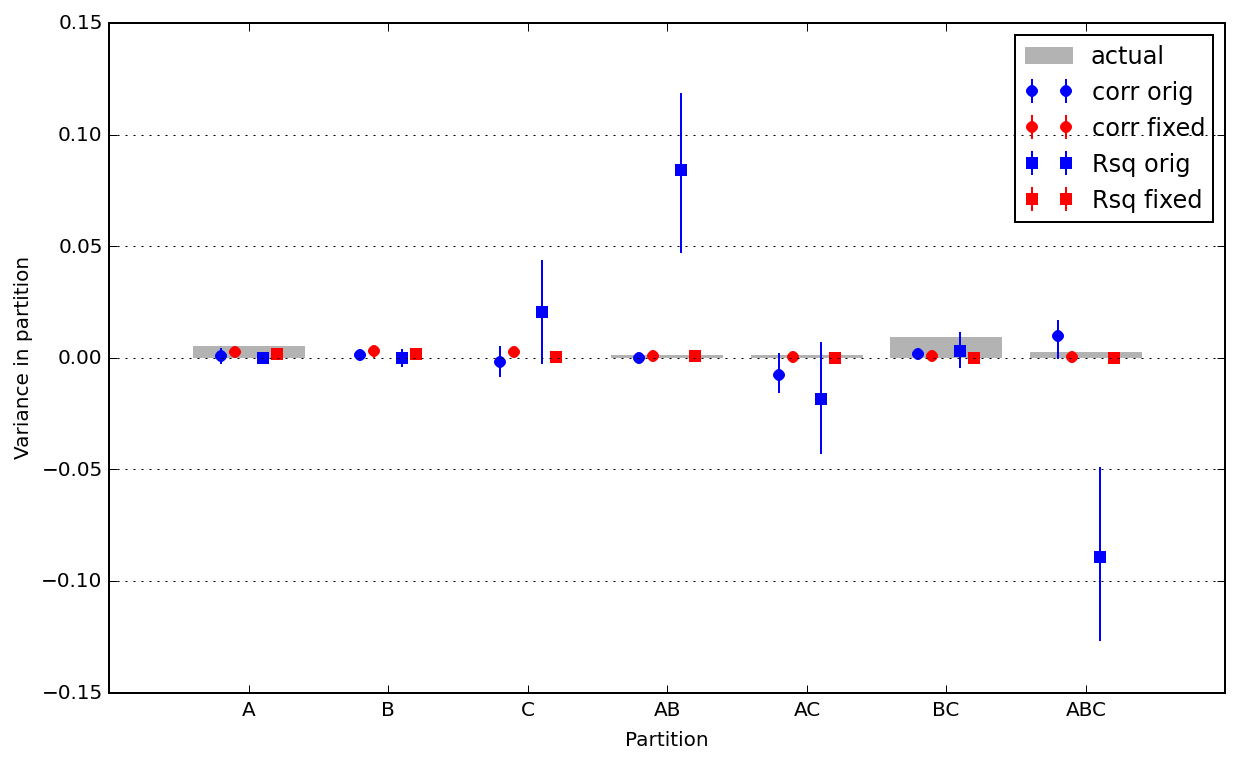

In [175]:
compare(dict(metric="corr"), dict(metric="rsq"), "corr", "Rsq", 
        data_params, data, verbose=False, nboots=10)

## Compare ridge regression vs. ordinary least squares (OLS)

ridge MSE: Orig: 0.000200, Fixed: 0.000030, Ratio: fixed 6.610x better
ols MSE:  Orig: 0.000390, Fixed: 0.000026, Ratio: fixed 14.806x better

ridge vs. ols fixed MSE: ridge 0.872x better

ridge Variance: Orig: 0.000171, Fixed: 0.000016, Ratio: fixed 10.557x better
ols Variance: Orig: 0.000354, Fixed: 0.000012, Ratio: fixed 29.416x better

ridge vs. ols fixed variance: ridge 0.744x better

ridge Bias: 
Orig: [-0.0046048   0.00121701 -0.00199433 -0.00132755 -0.00877082 -0.00737314
  0.00668692], 
Fixed: [-0.00311024  0.00311364  0.00247885 -0.00043046 -0.00117888 -0.00810526
 -0.00239562], 
Ratio: fixed 1.536x better

ols Bias: 
Orig: [-0.00690483  0.00071402 -0.00475173 -0.00184475 -0.00737441 -0.00783557
  0.00810773], 
Fixed: [-0.0034528   0.00265168  0.00165697 -0.00055528 -0.00108518 -0.00848684
 -0.00227427], 
Ratio: fixed 1.861x better

ridge vs. ols fixed bias: ridge 0.969x better


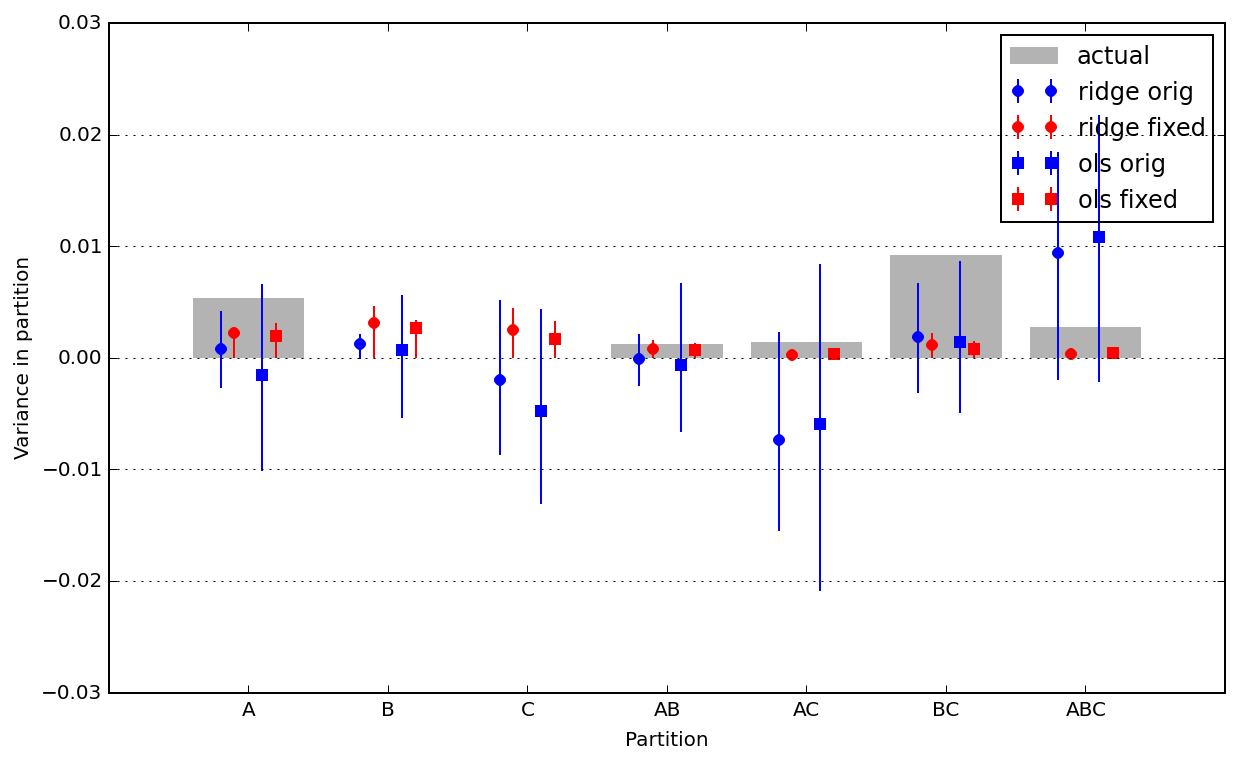

In [176]:
compare(dict(use_ols=False), dict(use_ols=True), "ridge", "ols", 
        data_params, data, verbose=False, nboots=10)

## Compare correction with unconstrained bias vs. negative-only bias

uncons-bias MSE: Orig: 0.000165, Fixed: 0.000030, Ratio: fixed 5.441x better
negonly-bias MSE:  Orig: 0.000198, Fixed: 0.000084, Ratio: fixed 2.348x better

uncons-bias vs. negonly-bias fixed MSE: uncons-bias 2.781x better

uncons-bias Variance: Orig: 0.000135, Fixed: 0.000016, Ratio: fixed 8.367x better
negonly-bias Variance: Orig: 0.000169, Fixed: 0.000060, Ratio: fixed 2.812x better

uncons-bias vs. negonly-bias fixed variance: uncons-bias 3.725x better

uncons-bias Bias: 
Orig: [-0.0046048   0.00121701 -0.00199433 -0.00132755 -0.00877082 -0.0075647
  0.00687847], 
Fixed: [-0.00288248  0.00292307  0.00255502 -0.00028071 -0.00121523 -0.00829227
 -0.00238886], 
Ratio: fixed 1.576x better

negonly-bias Bias: 
Orig: [-0.0046048   0.00121701 -0.00199433 -0.00132755 -0.00877082 -0.00731873
  0.0066325 ], 
Fixed: [-0.001247    0.00987848  0.00293054  0.00051748 -0.00102588 -0.00740663
 -0.00238198], 
Ratio: fixed 1.255x better

uncons-bias vs. negonly-bias fixed bias: uncons-bias 1.236x be

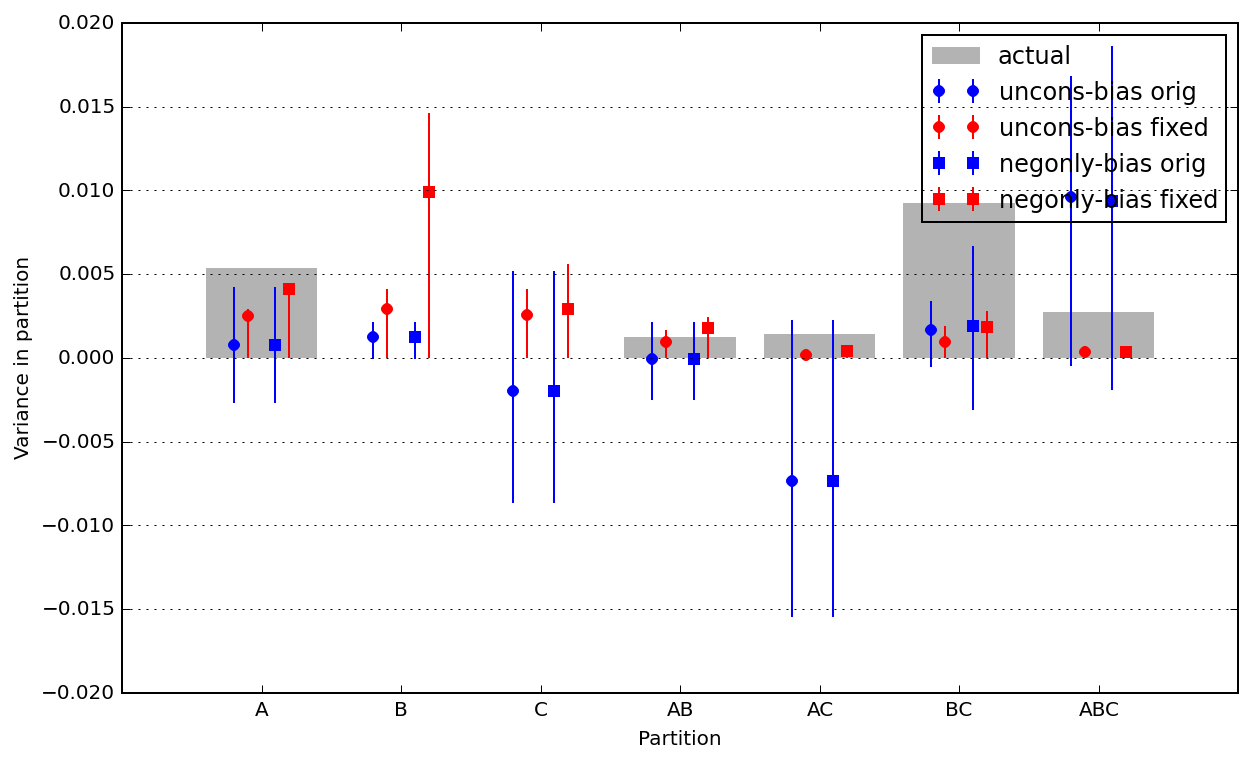

In [177]:
compare(dict(neg_only=False), dict(neg_only=True), "uncons-bias", "negonly-bias", 
        data_params, data, verbose=False)

## Compare bulked features vs. raw features

bulked MSE: Orig: 0.000091, Fixed: 0.000032, Ratio: fixed 2.874x better
raw MSE:  Orig: 0.000190, Fixed: 0.000030, Ratio: fixed 6.276x better

bulked vs. raw fixed MSE: bulked 0.952x better

bulked Variance: Orig: 0.000075, Fixed: 0.000016, Ratio: fixed 4.786x better
raw Variance: Orig: 0.000158, Fixed: 0.000016, Ratio: fixed 9.939x better

bulked vs. raw fixed variance: bulked 1.021x better

bulked Bias: 
Orig: [-0.00459044  0.00056826  0.00012743 -0.00142803 -0.00082431 -0.00952277
 -0.00123173], 
Fixed: [-0.00244569  0.00252471  0.00288075 -0.00107158 -0.00124292 -0.00908768
 -0.00268649], 
Ratio: fixed 0.834x better

raw Bias: 
Orig: [-0.00460357  0.00121701 -0.00164361 -0.00132878 -0.00912278 -0.00772468
  0.00703968], 
Fixed: [-0.00322226  0.00294115  0.00260753 -0.00037874 -0.00112786 -0.00818526
 -0.00241295], 
Ratio: fixed 1.565x better

bulked vs. raw fixed bias: bulked 0.952x better


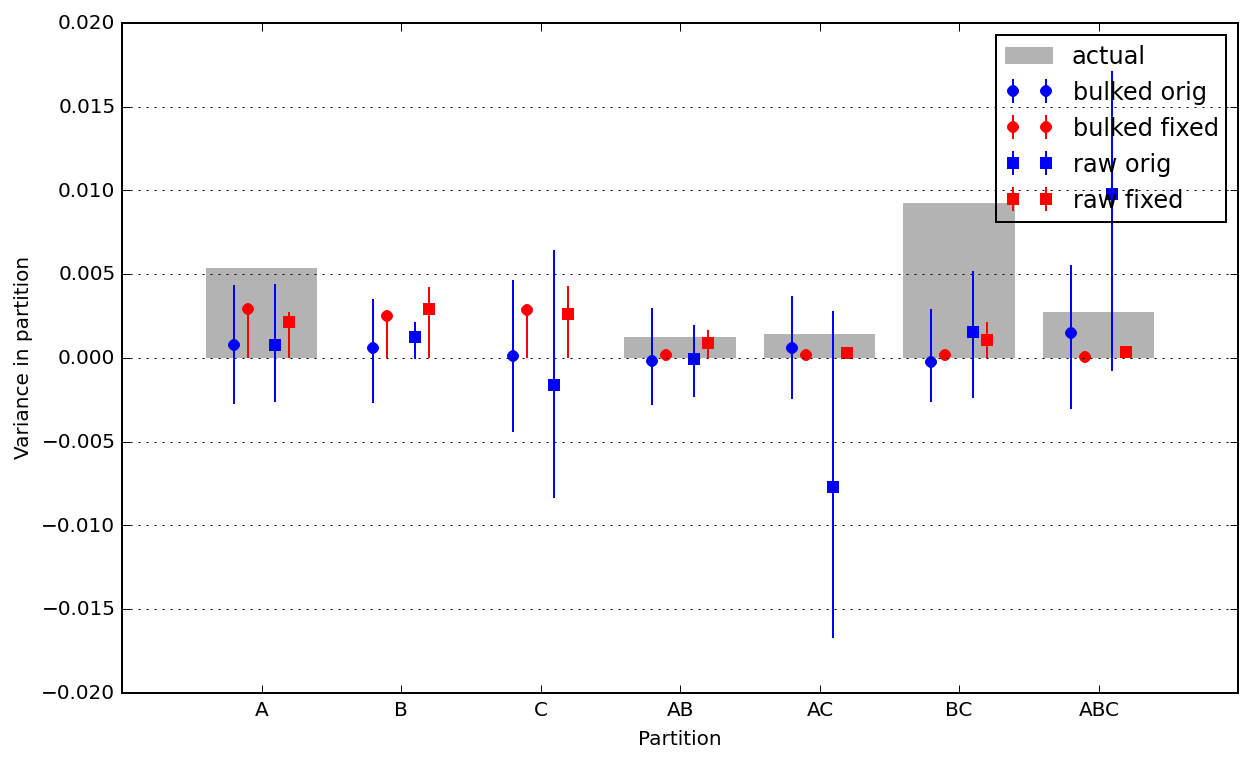

In [178]:
compare(dict(use_features="bulked"), dict(use_features="raw"), "bulked", "raw", 
        data_params, data, verbose=False)

## Compare same-size models vs. raw features

same MSE: Orig: 0.000251, Fixed: 0.000029, Ratio: fixed 8.762x better
raw MSE:  Orig: 0.000168, Fixed: 0.000031, Ratio: fixed 5.493x better

same vs. raw fixed MSE: same 1.066x better

same Variance: Orig: 0.000235, Fixed: 0.000013, Ratio: fixed 17.994x better
raw Variance: Orig: 0.000137, Fixed: 0.000016, Ratio: fixed 8.391x better

same vs. raw fixed variance: same 1.250x better

same Bias: 
Orig: [ -4.53050160e-03   1.23307601e-03   6.67438229e-05  -1.28815705e-03
   5.92244657e-04  -8.68020411e-03  -3.55992678e-03], 
Fixed: [-0.00308931  0.00138696  0.00337811 -0.00077981 -0.00100766 -0.00883583
 -0.00258747], 
Ratio: fixed 0.947x better

raw Bias: 
Orig: [-0.0046048   0.00121701 -0.00199433 -0.00132755 -0.00895286 -0.0075647
  0.00706051], 
Fixed: [-0.00289757  0.00295587  0.00255306 -0.00026936 -0.00122182 -0.00829103
 -0.0023855 ], 
Ratio: fixed 1.590x better

same vs. raw fixed bias: same 0.977x better


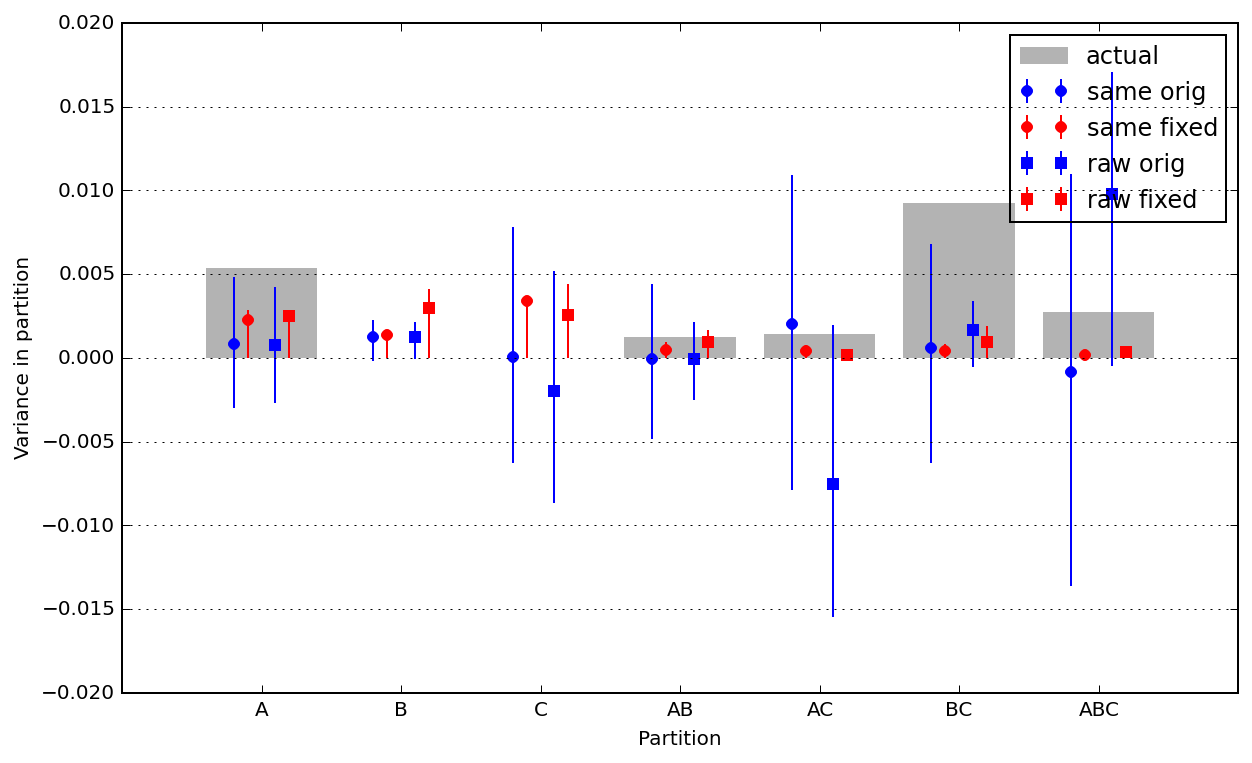

In [179]:
compare(dict(use_features="same"), dict(use_features="raw"), "same", "raw", 
        data_params, data, verbose=False)

## Compare L2 vs. L1 bias minimization in correction

min-L2-bias MSE: Orig: 0.000189, Fixed: 0.000030, Ratio: fixed 6.238x better
min-L1-bias MSE:  Orig: 0.000195, Fixed: 0.000083, Ratio: fixed 2.334x better

min-L2-bias vs. min-L1-bias fixed MSE: min-L2-bias 2.758x better

min-L2-bias Variance: Orig: 0.000158, Fixed: 0.000016, Ratio: fixed 9.887x better
min-L1-bias Variance: Orig: 0.000165, Fixed: 0.000061, Ratio: fixed 2.688x better

min-L2-bias vs. min-L1-bias fixed variance: min-L2-bias 3.852x better

min-L2-bias Bias: 
Orig: [-0.0046048   0.00121701 -0.00164361 -0.00132755 -0.00912155 -0.00766946
  0.00698323], 
Fixed: [-0.00323383  0.00294417  0.00260911 -0.0003695  -0.00113065 -0.00818843
 -0.00241317], 
Ratio: fixed 1.559x better

min-L1-bias Bias: 
Orig: [-0.00460357  0.00121701 -0.00199433 -0.00132878 -0.00895409 -0.00730015
  0.00679718], 
Fixed: [-0.00154453  0.00858254  0.00279914 -0.00041148 -0.00112899 -0.00795871
 -0.00238432], 
Ratio: fixed 1.298x better

min-L2-bias vs. min-L1-bias fixed bias: min-L2-bias 1.188x better


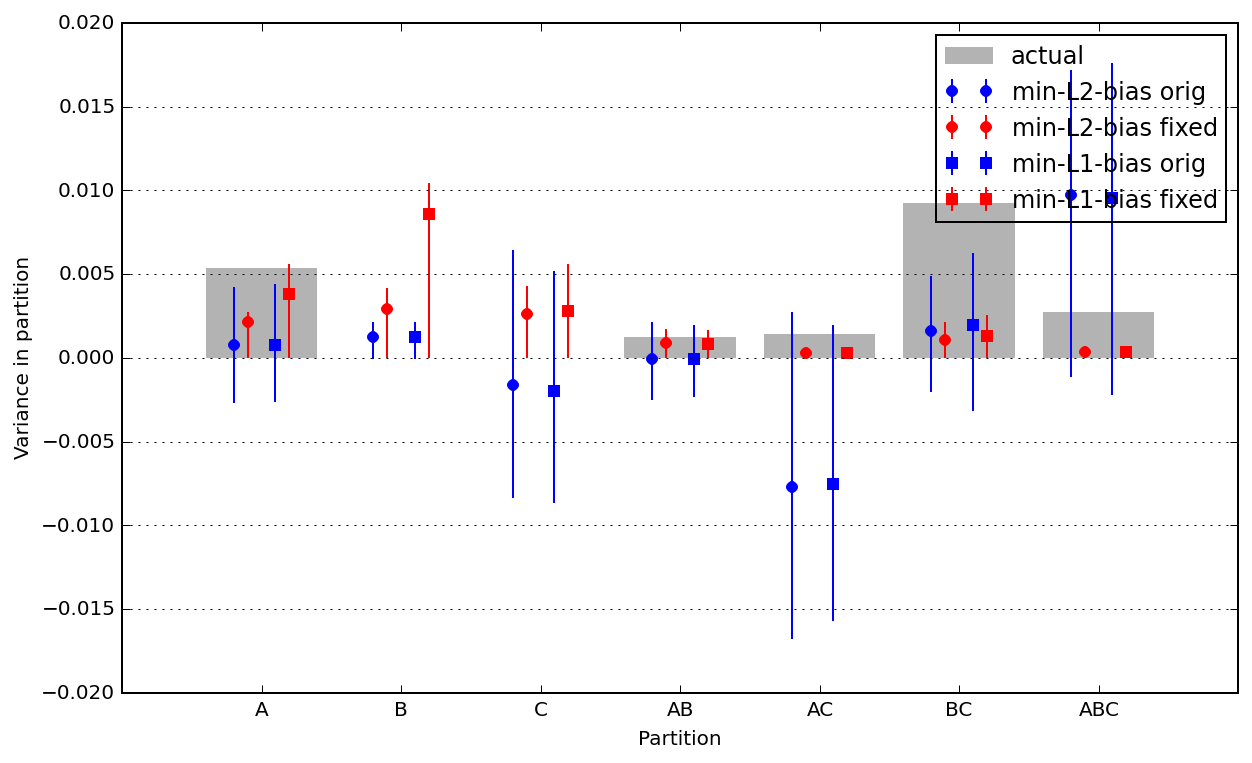

In [180]:
compare(dict(minimize="l2"), dict(minimize="l1"), "min-L2-bias", "min-L1-bias", 
        data_params, data, verbose=False)